# Generate simulated data

Generate simulated data by sampling from VAE latent sapce

Workflow:
1. Input gene expression data from 1 experiment (here we are assuming that there is only biological variation within this experiment)
2. Encode this input into a latent space using the trained VAE model
3. For each encoded feature, sample from a distribution using the the mean and standard deviation for that feature
4. Decode the samples

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
from keras.models import model_from_json, load_model
from ggplot import *
import umap

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
# Parameters
analysis_name = 'treatment'
experiment_id = 'E-GEOD-24036'
num_simulated_samples = 100

In [3]:
# Create directories
new_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('directory already exists: {}'.format(analysis_dir))
else:
    print('creating new directory: {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Batch_effects_simulation/data/simulated/treatment


In [4]:
# Load arguments
normalized_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "input",
    "train_set_normalized.pcl")

metadata_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "metadata",
    "sample_annotations.tsv")

model_encoder_file = glob.glob(os.path.join(
        os.path.dirname(os.getcwd()),
        "models",
        "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models",
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models", 
    "*_decoder_model.h5"))[0]


weights_decoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models",  
    "*_decoder_weights.h5"))[0]

# Output
simulated_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

In [5]:
# Read data
normalized_data = pd.read_table(normalized_data_file, header=0, sep='\t', index_col=0).T
normalized_data.shape

(950, 5549)

In [6]:
# Read in metadata
metadata = pd.read_table(metadata_file, header=0, sep='\t', index_col='ml_data_source')
metadata

,experiment,sample_name,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
ml_data_source,,,,,,,,,,,,,,,,,
GSM1141730_PA01_ZnO_PZO_.CEL,E-GEOD-46947,GSM1141730 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
GSM1141729_PA01_none_PC_.CEL,E-GEOD-46947,GSM1141729 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
GSM1608059_Planktonic_1.CEL,E-GEOD-65882,GSM1608059 1,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608060_Planktonic_2.CEL,E-GEOD-65882,GSM1608060 1,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608061_Planktonic_3.CEL,E-GEOD-65882,GSM1608061 1,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608062_Planktonic_4.CEL,E-GEOD-65882,GSM1608062 1,PAO1 WT. Planktonic. Rep4,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608067_Biofilm+12hrcipro_rep1.CEL,E-GEOD-65882,GSM1608067 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608068_Biofilm+12hrcipro_rep2.CEL,E-GEOD-65882,GSM1608068 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608069_Biofilm+12hrcipro_rep3.CEL,E-GEOD-65882,GSM1608069 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN


In [7]:
# read in saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

# load weights into new model
loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
# Metadata mapping
metadata_field = 'experiment'
metadata_map = metadata[metadata_field].to_frame()

metadata_map.head(5)

,experiment
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,E-GEOD-46947
GSM1141729_PA01_none_PC_.CEL,E-GEOD-46947
GSM1608059_Planktonic_1.CEL,E-GEOD-65882
GSM1608060_Planktonic_2.CEL,E-GEOD-65882
GSM1608061_Planktonic_3.CEL,E-GEOD-65882


## Select experiment(s)

In [9]:
# Select input experiment
selected_samples = list(metadata_map[metadata_map['experiment'] == experiment_id].index)

print(len(selected_samples))

data_selected = normalized_data.loc[selected_samples]
data_selected.head(5)

18


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM591496.CEL,0.758438,0.808715,0.626747,0.774033,0.514039,0.383739,0.343325,0.719577,0.541627,0.216560,...,0.245720,0.671244,0.670357,0.767884,0.640626,0.151623,0.659674,0.643497,0.746590,0.707505
GSM591601.CEL,0.702824,0.755786,0.537629,0.755608,0.462175,0.316667,0.308082,0.704596,0.558551,0.160684,...,0.214021,0.653341,0.668257,0.686663,0.630709,0.182788,0.703150,0.649179,0.739723,0.728428
GSM591602.CEL,0.776721,0.736631,0.582667,0.749297,0.486610,0.302209,0.323932,0.782628,0.807336,0.225348,...,0.171650,0.560667,0.688716,0.699709,0.647261,0.163239,0.589900,0.649514,0.724675,0.696667
GSM591603.CEL,0.650666,0.733063,0.484848,0.682237,0.404460,0.314539,0.461867,0.569701,0.396897,0.201233,...,0.248430,0.533048,0.536321,0.565483,0.565437,0.290283,0.518061,0.411037,0.675788,0.625928
GSM591622.CEL,0.667370,0.710359,0.466625,0.627510,0.389397,0.330307,0.557265,0.504433,0.340656,0.158090,...,0.247211,0.480189,0.524795,0.570522,0.514418,0.238918,0.437085,0.393830,0.658838,0.614567


## Plot input data using UMAP

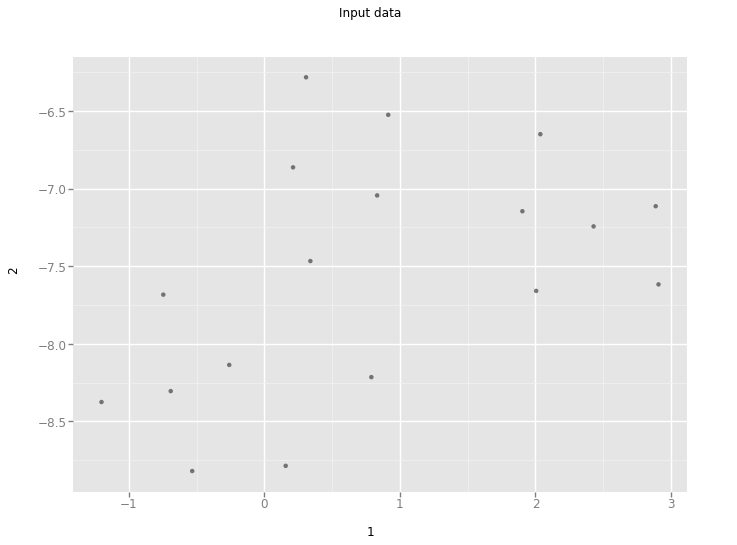

<ggplot: (-9223363300970326247)>


In [10]:
# UMAP embedding of selected data
input_data_UMAPencoded = umap.UMAP().fit_transform(data_selected)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=data_selected.index,
                                         columns=['1','2'])


g = ggplot(aes(x='1',y='2'), data=input_data_UMAPencoded_df) + \
            geom_point(alpha=0.5) + \
            scale_color_brewer(type='qual', palette='Set2') + \
            ggtitle("Input data")

print(g)

## Simulate data

Generate new simulated data by sampling from the distribution of latent space features.  In other words, for each latent space feature get the mean and standard deviation.  Then we can generate a new sample by sampling from a distribution with this mean and standard deviation.

In [11]:
# Simulate data

# Encode into latent space
data_selected_encoded = loaded_model.predict_on_batch(data_selected)
data_selected_encoded_df = pd.DataFrame(data_selected_encoded, index=data_selected.index)

latent_dim = data_selected_encoded_df.shape[1]

# Get mean and standard deviation per encoded feature
encoded_means = data_selected_encoded_df.mean(axis=0)

encoded_stds = data_selected_encoded_df.std(axis=0)

# Generate samples
new_data = np.zeros([num_simulated_samples,latent_dim])
for j in range(latent_dim):
    new_data[:,j] = np.random.normal(encoded_means[j], encoded_stds[j], num_simulated_samples) 

new_data_df = pd.DataFrame(data=new_data)

# Decode N samples
new_data_decoded = loaded_decode_model.predict_on_batch(new_data_df)
new_data_decoded_df = pd.DataFrame(data=new_data_decoded)

new_data_decoded_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.628963,0.646908,0.480636,0.620393,0.422232,0.382635,0.402595,0.553750,0.520048,0.258603,...,0.359013,0.551646,0.611666,0.598276,0.628137,0.287001,0.529758,0.509939,0.633529,0.619871
1,0.678382,0.703188,0.527437,0.704238,0.430164,0.368354,0.352613,0.620724,0.549424,0.245592,...,0.290579,0.558925,0.627152,0.640999,0.608726,0.258124,0.593195,0.531552,0.668047,0.636569
2,0.641916,0.678263,0.463933,0.648859,0.409863,0.350796,0.389504,0.537631,0.512888,0.260378,...,0.330708,0.536779,0.598897,0.578997,0.599701,0.278488,0.516988,0.463365,0.624215,0.609901
3,0.594767,0.636643,0.416453,0.628747,0.416945,0.351811,0.360039,0.535116,0.497940,0.247161,...,0.321353,0.538036,0.635792,0.567058,0.585936,0.300398,0.530513,0.518424,0.635868,0.630736
4,0.640293,0.671701,0.469927,0.638791,0.417401,0.379394,0.344619,0.545680,0.521381,0.243920,...,0.351509,0.556058,0.630285,0.597943,0.630032,0.268888,0.538156,0.488934,0.651016,0.637002
5,0.570821,0.614700,0.416570,0.604431,0.416258,0.360512,0.358066,0.490945,0.439193,0.246254,...,0.367628,0.549973,0.604247,0.556710,0.583859,0.290600,0.514078,0.480668,0.605616,0.590259
6,0.645699,0.667780,0.458968,0.638642,0.397041,0.350572,0.376161,0.553894,0.503936,0.227837,...,0.304722,0.536893,0.607844,0.574936,0.595981,0.249020,0.486854,0.504910,0.648401,0.630152
7,0.596162,0.595165,0.455493,0.570292,0.422777,0.393874,0.380671,0.522127,0.467170,0.259574,...,0.374777,0.547841,0.605506,0.556260,0.571638,0.298073,0.522282,0.468431,0.593866,0.586248
8,0.634383,0.675939,0.478415,0.639174,0.427510,0.360819,0.372903,0.576739,0.521625,0.250696,...,0.331871,0.548516,0.630932,0.604443,0.607249,0.264769,0.530942,0.530084,0.666258,0.651207
9,0.631214,0.669070,0.428945,0.636960,0.437791,0.365943,0.337859,0.505509,0.479455,0.242183,...,0.329414,0.559434,0.628833,0.567533,0.591657,0.289760,0.493780,0.462707,0.642027,0.619266


In [12]:
# Output
new_data_decoded_df.to_csv(simulated_data_file, sep='\t')